## Desarrollo de proyecto

### Paso 1. Librerías

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
pd.options.display.float_format = '{:,.0f}'.format

### Paso 2. Carga y división del conjunto de datos

In [2]:
# cargamos los datos
data = np.load('proyecto_training_data.npy')

In [3]:
# los transformamos en un dataframe con columnas nombradas de acuerdo al Data fields.txt
df_data = pd.DataFrame(data,columns=['SalePrice','OveralQuad','1stFlrSF',
                                     'TotRmsAbvGrd','YearBuilt','LotFrontage']
                      )
print(f"Cantidad de registros: {df_data.shape[0]}")
print(f"Cantidad de columnas: {df_data.shape[1]}\n")
df_data.head()

Cantidad de registros: 1460
Cantidad de columnas: 6



,SalePrice,OveralQuad,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
0,"208,500",7,856,8,"2,003",65
1,"181,500",6,"1,262",6,"1,976",80
2,"223,500",7,920,6,"2,001",68
3,"140,000",7,961,7,"1,915",60
4,"250,000",8,"1,145",9,"2,000",84


In [4]:
# se seleccionan aleatoriamente 1168 índices (el 80%) del data set para el set de entrenamiento
training_index = []
cant_reg = data.shape[0]
while len(training_index) <= int(cant_reg*0.8):
    num = random.randint(0,cant_reg - 1)
    # No se toman índices repetidos
    if num in training_index:
        continue
    else:
        training_index.append(num)

In [5]:
# para el set de prueba se seleccionan los demás índices que no se tomaron para el
# set de entrenamiento. Se hace una diferencia de conjuntos.
total_index = [i for i in range(0,cant_reg-1)]
test_index = list(set(total_index).difference(set(training_index)))

In [6]:
# se forman los set de entrenamiento y prueba con los índices obtenidos anteriormente
training_data = data[np.array(training_index)]
test_data = data[np.array(test_index)]

### Paso 3. Análisis explotario de variables

In [7]:
for col in df_data.columns:
    print(f'Variable {col}\n{30*"-"}')
    mean = df_data[col].mean() 
    print(f'{mean = :,.2f}')
    min = df_data[col].min() 
    print(f'{min = :,.2f}')
    max = df_data[col].max() 
    print(f'{max = :,.2f}')
    peak = max - min
    print(f'{peak = :,.2f}')
    std = df_data[col].std() 
    print(f'{std = :,.2f}')
    print(f"{30*'-'}\n")

Variable SalePrice
------------------------------
mean = 180,921.20
min = 34,900.00
max = 755,000.00
peak = 720,100.00
std = 79,442.50
------------------------------

Variable OveralQuad
------------------------------
mean = 6.10
min = 1.00
max = 10.00
peak = 9.00
std = 1.38
------------------------------

Variable 1stFlrSF
------------------------------
mean = 1,162.63
min = 334.00
max = 4,692.00
peak = 4,358.00
std = 386.59
------------------------------

Variable TotRmsAbvGrd
------------------------------
mean = 6.52
min = 2.00
max = 14.00
peak = 12.00
std = 1.63
------------------------------

Variable YearBuilt
------------------------------
mean = 1,971.27
min = 1,872.00
max = 2,010.00
peak = 138.00
std = 30.20
------------------------------

Variable LotFrontage
------------------------------
mean = 70.05
min = 21.00
max = 313.00
peak = 292.00
std = 24.28
------------------------------



### Paso 4. Análisis gráfico por variable

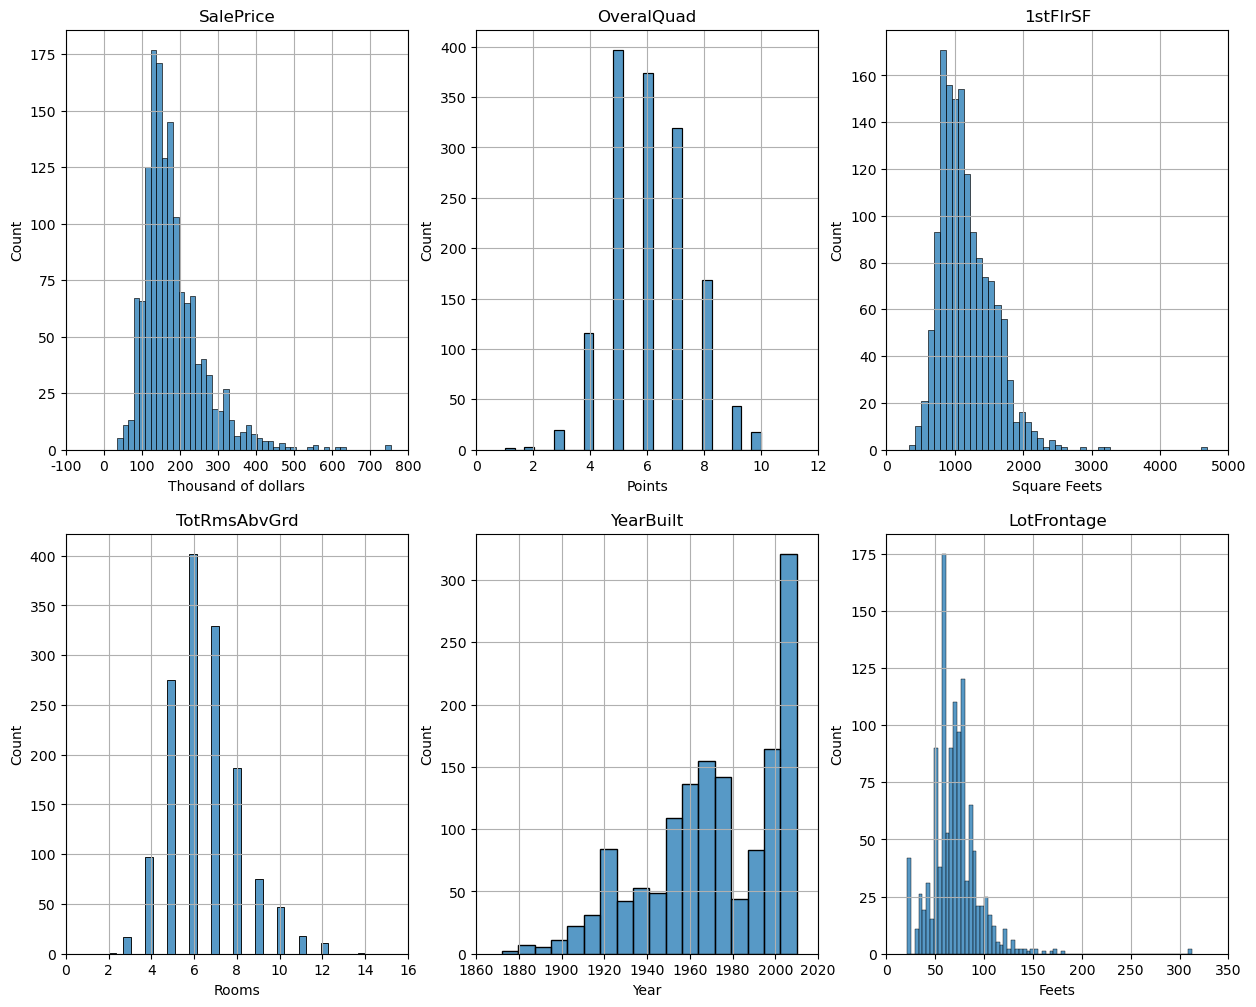

In [8]:
nxm = len(df_data.columns)
n = 2
m = 3
units = ['Thousand of dollars','Points','Square Feets','Rooms','Year','Feets']
fig, ax =  plt.subplots(n,m, figsize=(15,12))
for i, col in enumerate(df_data.columns):
    graf = sns.histplot(data=df_data[col], ax=ax[i//m,i%m])
    graf.set_title(col)
    xtick = graf.get_xticks() if col != 'SalePrice' else graf.get_xticks()/1e3
    xticklabel = [f"{int(val)}" for val in graf.get_xticks()] if col != 'SalePrice' else [f"{int(val)}" for val in graf.get_xticks()/1e3]
    graf.set_xticks(graf.get_xticks())
    graf.set_xticklabels(xticklabel)
    graf.set_xlabel(units[i])
    graf.grid()
plt.show()

### Paso 5. Correlación

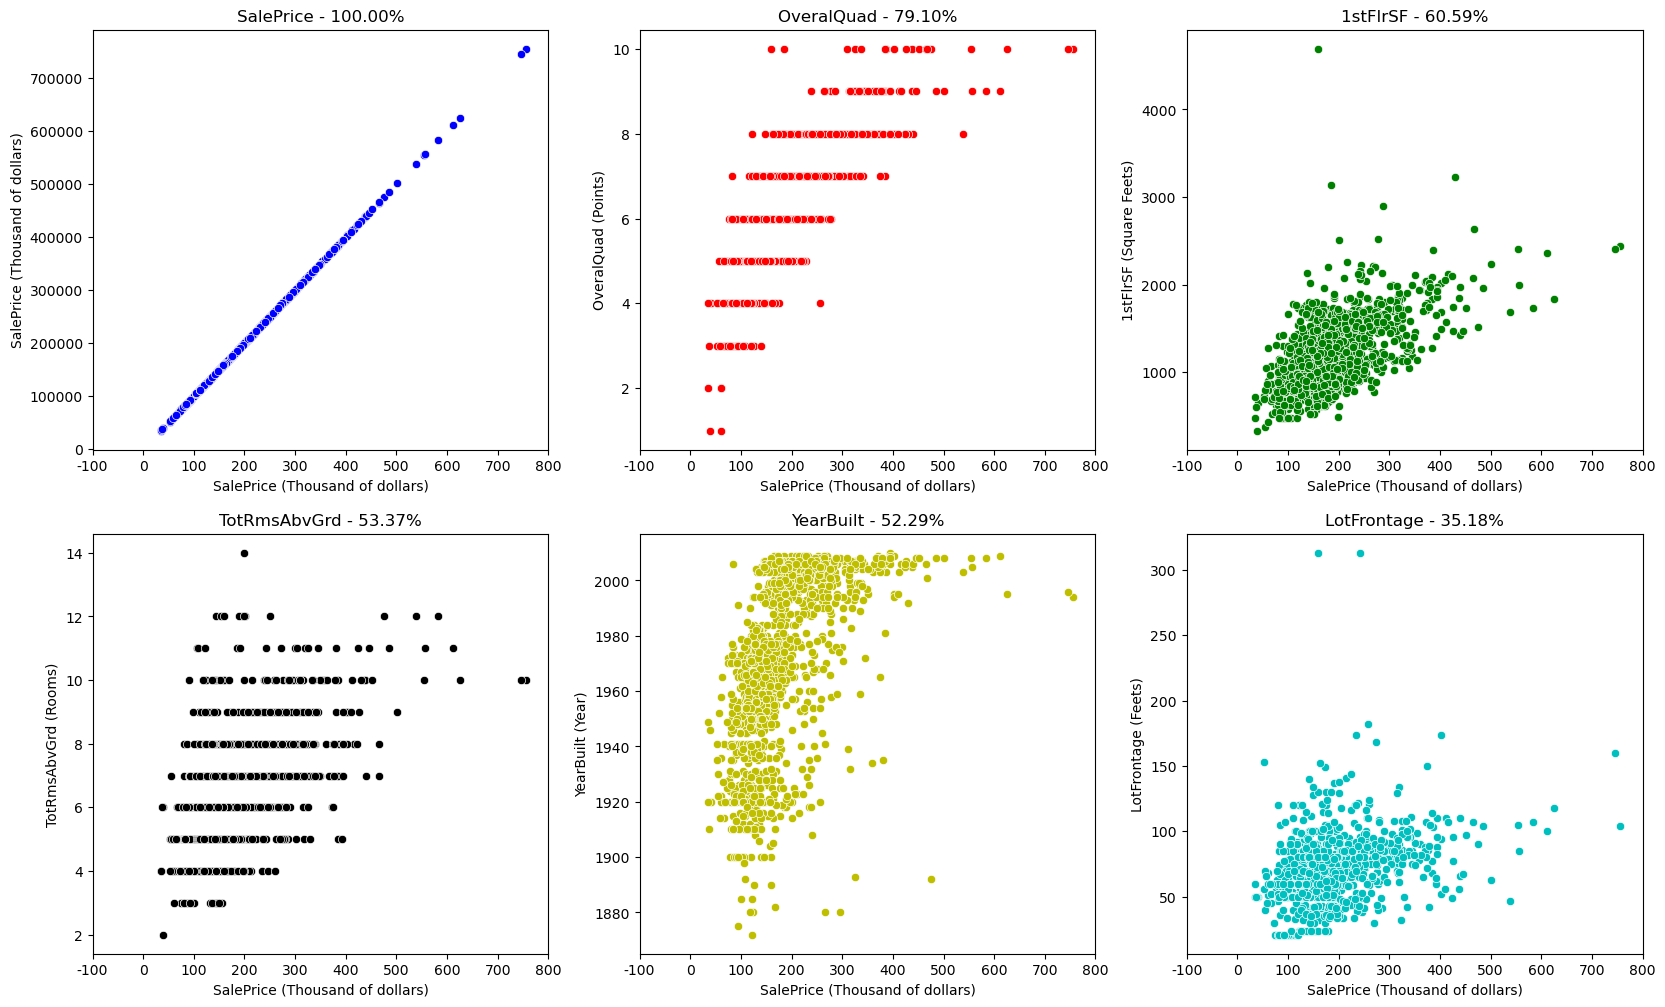

In [9]:
fig, ax =  plt.subplots(n,m, figsize=(20,12))
colors = ['b','r','g','k','y','c']
units = ['Thousand of dollars','Points','Square Feets','Rooms','Year','Feets']
for i, col in enumerate(df_data.columns):
    correlacion = df_data.SalePrice.corr(df_data[col])
    scat = sns.scatterplot(x=df_data.SalePrice,y=df_data[col], ax=ax[i//m,i%m], color=colors[i])
    xtick = scat.get_xticks()/1e3
    xticklabel = [f"{int(val)}" for val in scat.get_xticks()/1e3]
    scat.set_xticks(scat.get_xticks())
    scat.set_xticklabels(xticklabel)
    scat.set_title(f"{col} - {correlacion*100:.2f}%")
    scat.set_xlabel("SalePrice (Thousand of dollars)")
    scat.set_ylabel(f"{col} ({units[i]})")
plt.show()

Con base en el anterior análisis, se escogen los campos ***OveralQuad*** y ***1stFlrSF*** para realizar los modelos,
ya que presentan la mayor correlación con la variable de salida ***SalePice***, lo que significa que el material y el acabado
de la casa, y  el área del primer nivel influencian más en el precio de la casa.

### Paso 6. Función para entrenar modelo

In [10]:
def entrenar_modelo(x, y, epochs, imprimir_error_cada, alpha):
    iters = dict()
    vec_err = []
    ones = np.ones_like(x.reshape(-1,1))
    A = np.hstack([x.reshape(-1,1), ones])
    b0 = 10000.0
    b1 = 5000.0
    betas = np.array([b1,b0])
    for n in range(1,epochs+1):
        y_pred = np.matmul(A, betas)
        err = ((y - y_pred)**2).sum()/(2*len(y))
        vec_err.append(err)
        grad = np.matmul((y_pred - y)/len(y), A)
        betas -= alpha*grad
        iters[n] = {'b1':betas[0], 'b0':betas[1]}
        if n%imprimir_error_cada == 0:
            print(f'Iteración {n}: Error {err}')
    return iters, np.array(vec_err)

In [11]:
def plot_error(error):
    errSeries = pd.Series(error)
    plt.figure(figsize=(15,5))
    plt.plot(errSeries.index, errSeries.values, color='r')
    plt.title('Error del Modelo')
    plt.xlabel('No. Iteración')
    plt.ylabel('Error')
    plt.grid(linewidth=0.5)
    plt.show()

In [12]:
def plot_model(model, n=5):
    x = np.arange(0,len(model)+1,n/2)
    plt.figure(figsize=(15,7))
    for i in range(1,len(model)+1):
        if i%n == 0:
            plt.plot(x, model[i]['b1']*x + model[i]['b0'], 
                     linewidth=1, alpha=0.7,
                     label=f"y = {model[i]['b1']:.0f}x + {model[i]['b0']:.0f}, iteración: {i}")
    plt.title('Modelos')
    plt.xlabel('x (1e3)')
    plt.ylabel('y(x)')
    plt.xticks(x, [k/1000 for k in x])
    plt.legend()
    plt.grid()
    plt.show()

### Paso 7. Entrenamiento de modelos

#### Modelo con variable Overal Quad

In [13]:
y_train_ov = training_data[:,0]
x_train_ov = training_data[:,1]

In [14]:
overalQuadModel, OvModelError = entrenar_modelo(x_train_ov,y_train_ov,100000,5000,1e-3)

Iteración 5000: Error 1478228039.073111
Iteración 10000: Error 1399087085.800468
Iteración 15000: Error 1349962327.6183763
Iteración 20000: Error 1319469368.326677
Iteración 25000: Error 1300541630.0379992
Iteración 30000: Error 1288792712.0895133
Iteración 35000: Error 1281499866.4861472
Iteración 40000: Error 1276973015.8240075
Iteración 45000: Error 1274163087.0209262
Iteración 50000: Error 1272418894.3210392
Iteración 55000: Error 1271336230.5286314
Iteración 60000: Error 1270664194.1834123
Iteración 65000: Error 1270247044.5082648
Iteración 70000: Error 1269988109.3290703
Iteración 75000: Error 1269827381.8228073
Iteración 80000: Error 1269727614.2618682
Iteración 85000: Error 1269665686.0552592
Iteración 90000: Error 1269627245.677066
Iteración 95000: Error 1269603384.7781882
Iteración 100000: Error 1269588573.7247586


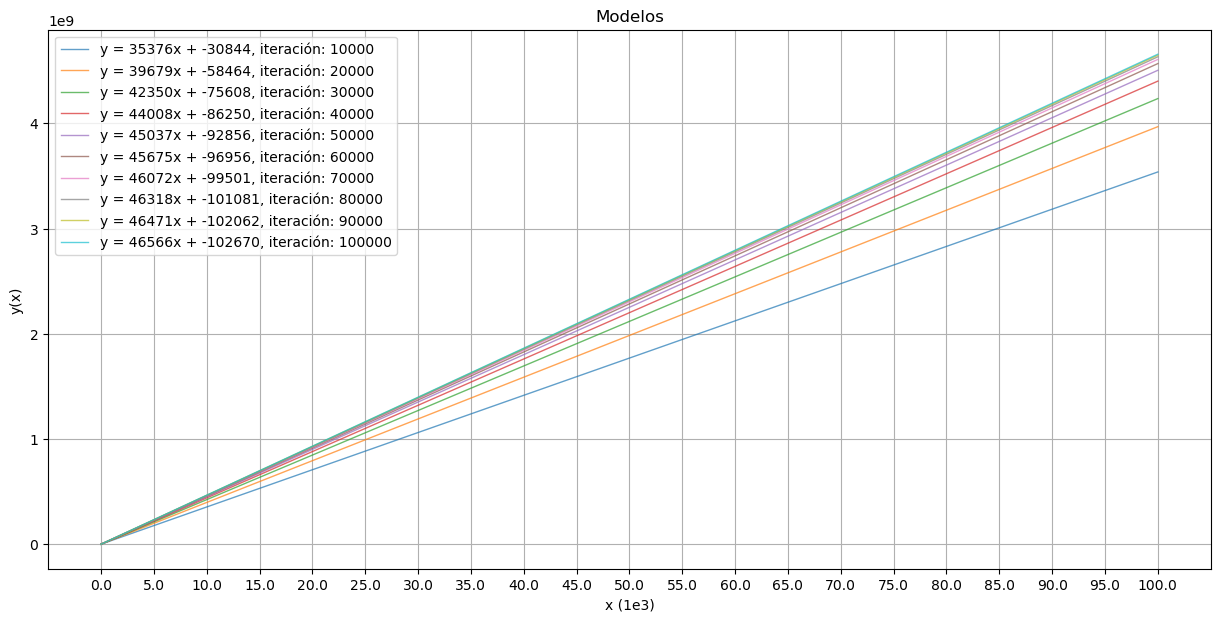

In [15]:
plot_model(overalQuadModel,10000)

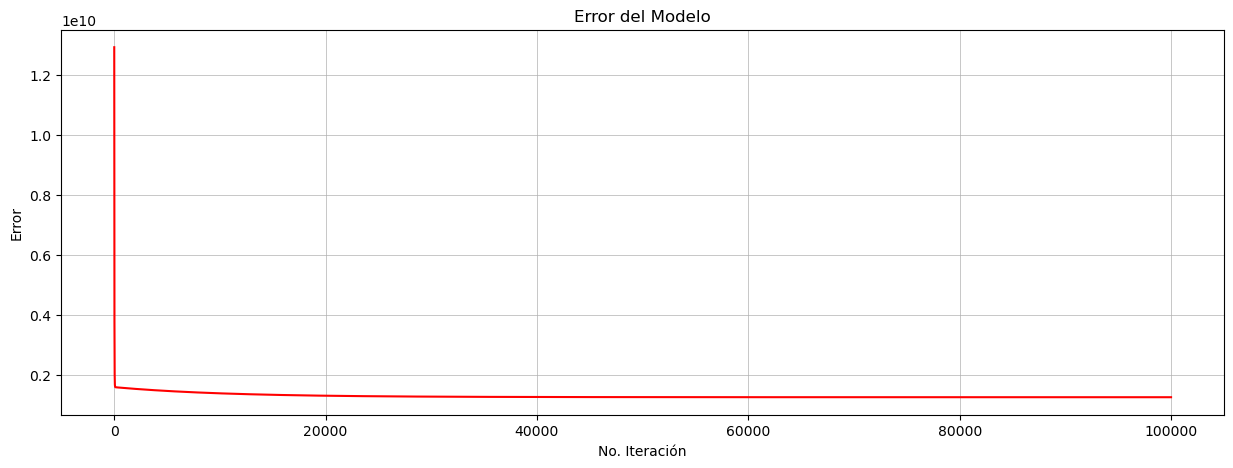

In [16]:
plot_error(OvModelError)

#### Modelo con variable First Floor SF

In [17]:
y_train_fl = training_data[:,0]
x_train_fl = training_data[:,2]

In [18]:
firstFlrdModel, FlrModelError = entrenar_modelo(x_train_fl,y_train_fl,500000,20000,1.3e-6)

Iteración 20000: Error 2108148583.1141284
Iteración 40000: Error 2108030022.868624
Iteración 60000: Error 2107912084.4784195
Iteración 80000: Error 2107794764.6818485
Iteración 100000: Error 2107678060.2343516
Iteración 120000: Error 2107561967.9083874
Iteración 140000: Error 2107446484.4933436
Iteración 160000: Error 2107331606.7954473
Iteración 180000: Error 2107217331.6376774
Iteración 200000: Error 2107103655.8596761
Iteración 220000: Error 2106990576.3176618
Iteración 240000: Error 2106878089.884343
Iteración 260000: Error 2106766193.4488304
Iteración 280000: Error 2106654883.9165518
Iteración 300000: Error 2106544158.209166
Iteración 320000: Error 2106434013.2644775
Iteración 340000: Error 2106324446.0363529
Iteración 360000: Error 2106215453.494635
Iteración 380000: Error 2106107032.6250618
Iteración 400000: Error 2105999180.4291782
Iteración 420000: Error 2105891893.92426
Iteración 440000: Error 2105785170.1432252
Iteración 460000: Error 2105679006.134553
Iteración 480000: Erro

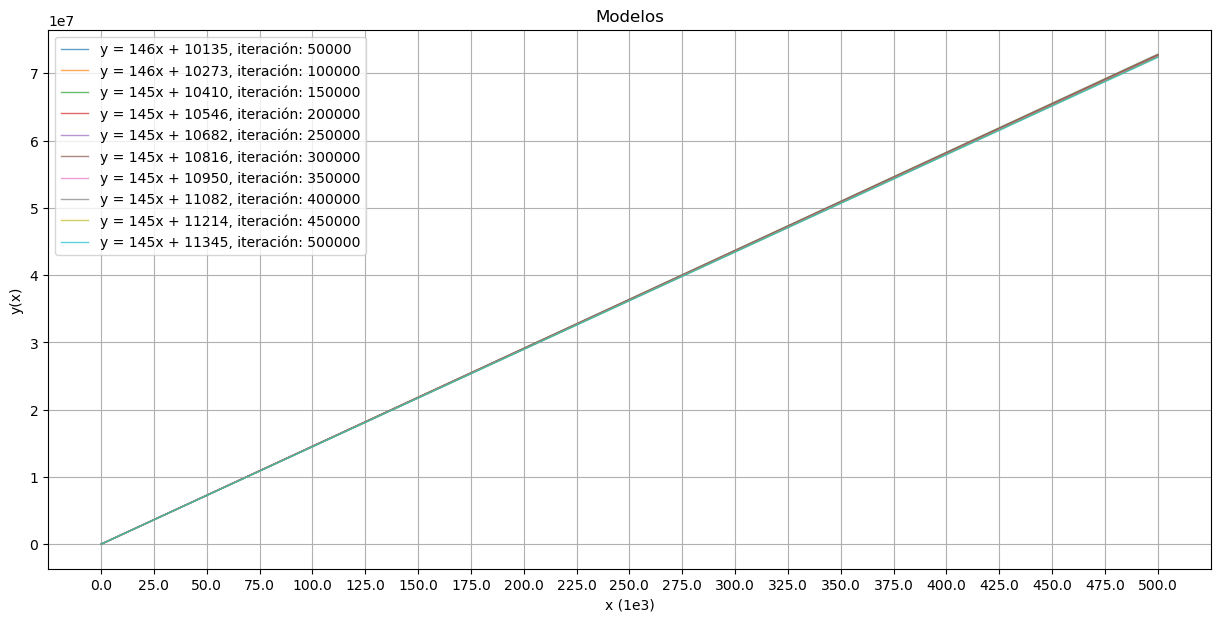

In [19]:
plot_model(firstFlrdModel,50000)

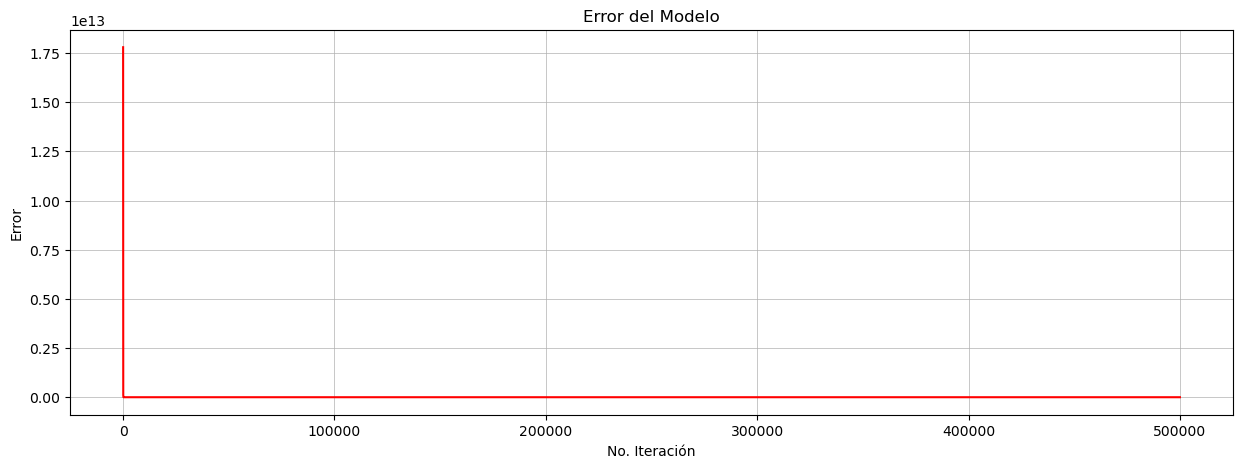

In [20]:
plot_error(FlrModelError)

#### Clase para cargar data, dividirla y analizarla (pasos 1 - 5)

In [2]:
class dataset_loadNanalysis():
    def __init__(self, filename, train_prop, columns=None, target_name=None, units=None):
        self.filename = filename
        self.train_prop = train_prop
        self.columns = columns
        self.target_name = target_name
        self.units = units
        self.dataset = np.load(filename)

    def divide_dataset(self):
        training_index = []
        cant_reg = self.dataset.shape[0]
        while len(training_index) <= int(cant_reg*self.train_prop):
            num = random.randint(0,cant_reg - 1)
            if num in training_index:
                continue
            else:
                training_index.append(num)
        total_index = [i for i in range(0,cant_reg-1)]
        test_index = list(set(total_index).difference(set(training_index)))
        training_data = self.dataset[np.array(training_index)]
        test_data = self.dataset[np.array(test_index)]
        return training_data, test_data

    def exp_analysis(self):
        self.df_data = pd.DataFrame(self.dataset,columns=self.columns)
        print(f"Cantidad de registros: {self.df_data.shape[0]}")
        print(f"Cantidad de columnas: {self.df_data.shape[1]}\n")
        print(f"Columnas: {self.df_data.columns}")
        print(100*'-')
        for col in self.df_data.columns:
            print(f'Variable {col}\n{30*"-"}')
            mean = self.df_data[col].mean() 
            print(f'{mean = :,.2f}')
            min = self.df_data[col].min() 
            print(f'{min = :,.2f}')
            max = self.df_data[col].max() 
            print(f'{max = :,.2f}')
            peak = max - min
            print(f'{peak = :,.2f}')
            std = self.df_data[col].std() 
            print(f'{std = :,.2f}')
            print(f"{30*'-'}\n")

    def graf_analysis(self, n=2, m=3):
        units = self.units
        target_name = self.target_name
        fig, ax =  plt.subplots(n,m, figsize=(15,12))
        for i, col in enumerate(self.df_data.columns):
            graf = sns.histplot(data=self.df_data[col], ax=ax[i//m,i%m])
            graf.set_title(col)
            xtick = graf.get_xticks() if col not in [target_name, None] else graf.get_xticks()/1e3
            xticklabel = [f"{int(val)}" for val in graf.get_xticks()] if col not in [target_name, None] else [f"{int(val)}" for val in graf.get_xticks()/1e3]
            graf.set_xticks(graf.get_xticks())
            graf.set_xticklabels(xticklabel)
            if units is not None: graf.set_xlabel(units[i]) 
            else: graf.set_xlabel(None)
            graf.grid()
        plt.show()

    def correlation(self, n=2, m=3):
        fig, ax =  plt.subplots(n,m, figsize=(20,12))
        colors = ['b','r','g','k','y','c']
        units = self.units
        target_name = self.target_name
        for i, col in enumerate(self.df_data.columns):
            correlacion = self.df_data[target_name].corr(self.df_data[col])
            scat = sns.scatterplot(x=self.df_data[target_name],y=self.df_data[col], ax=ax[i//m,i%m], color=colors[i])
            xtick = scat.get_xticks()/1e3
            xticklabel = [f"{int(val)}" for val in scat.get_xticks()/1e3]
            scat.set_xticks(scat.get_xticks())
            scat.set_xticklabels(xticklabel)
            scat.set_title(f"{col} - {correlacion*100:.2f}%")
            scat.set_xlabel("SalePrice (Thousand of dollars)")
            scat.set_ylabel(f"{col} ({units[i]})")
        plt.show()

##### Se carga data

In [3]:
dataset = dataset_loadNanalysis(filename='proyecto_training_data.npy',
                              train_prop = 0.8, columns=['SalePrice','OveralQuad','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'],
                              target_name='SalePrice',
                              units=['Thousand of dollars','Points','Square Feets','Rooms','Year','Feets'])

##### Se divide la data

In [4]:
train, test = dataset.divide_dataset()

##### Estadística descriptiva de la data

In [5]:
dataset.exp_analysis()

Cantidad de registros: 1460
Cantidad de columnas: 6

Columnas: Index(['SalePrice', 'OveralQuad', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt',
       'LotFrontage'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Variable SalePrice
------------------------------
mean = 180,921.20
min = 34,900.00
max = 755,000.00
peak = 720,100.00
std = 79,442.50
------------------------------

Variable OveralQuad
------------------------------
mean = 6.10
min = 1.00
max = 10.00
peak = 9.00
std = 1.38
------------------------------

Variable 1stFlrSF
------------------------------
mean = 1,162.63
min = 334.00
max = 4,692.00
peak = 4,358.00
std = 386.59
------------------------------

Variable TotRmsAbvGrd
------------------------------
mean = 6.52
min = 2.00
max = 14.00
peak = 12.00
std = 1.63
------------------------------

Variable YearBuilt
------------------------------
mean = 1,971.27
min = 1,872.00
max = 2,010.00
peak = 138.00


##### Análisis gráfico de la data

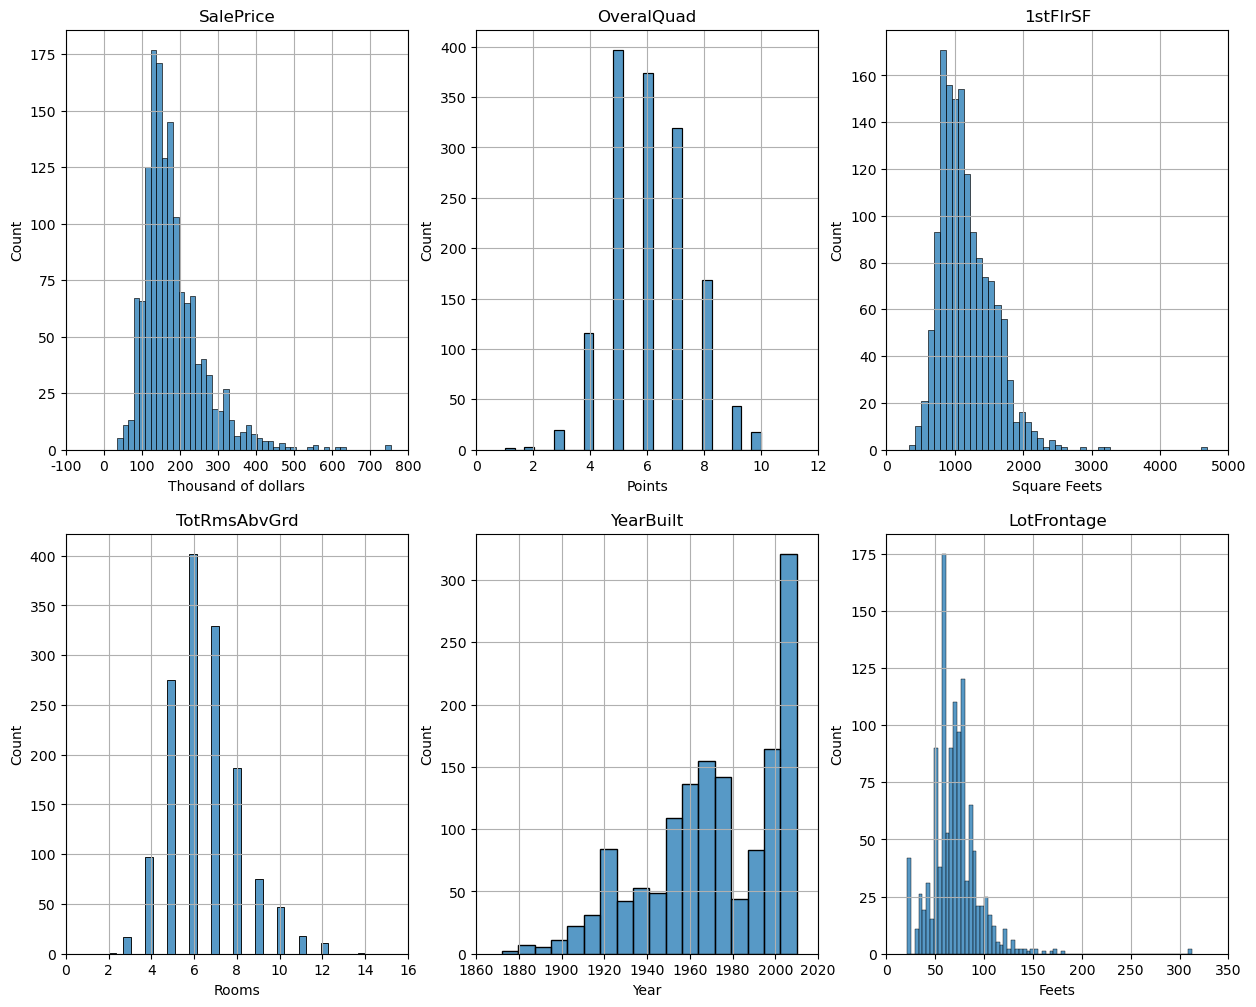

In [6]:
dataset.graf_analysis()

##### Correlación entre variables

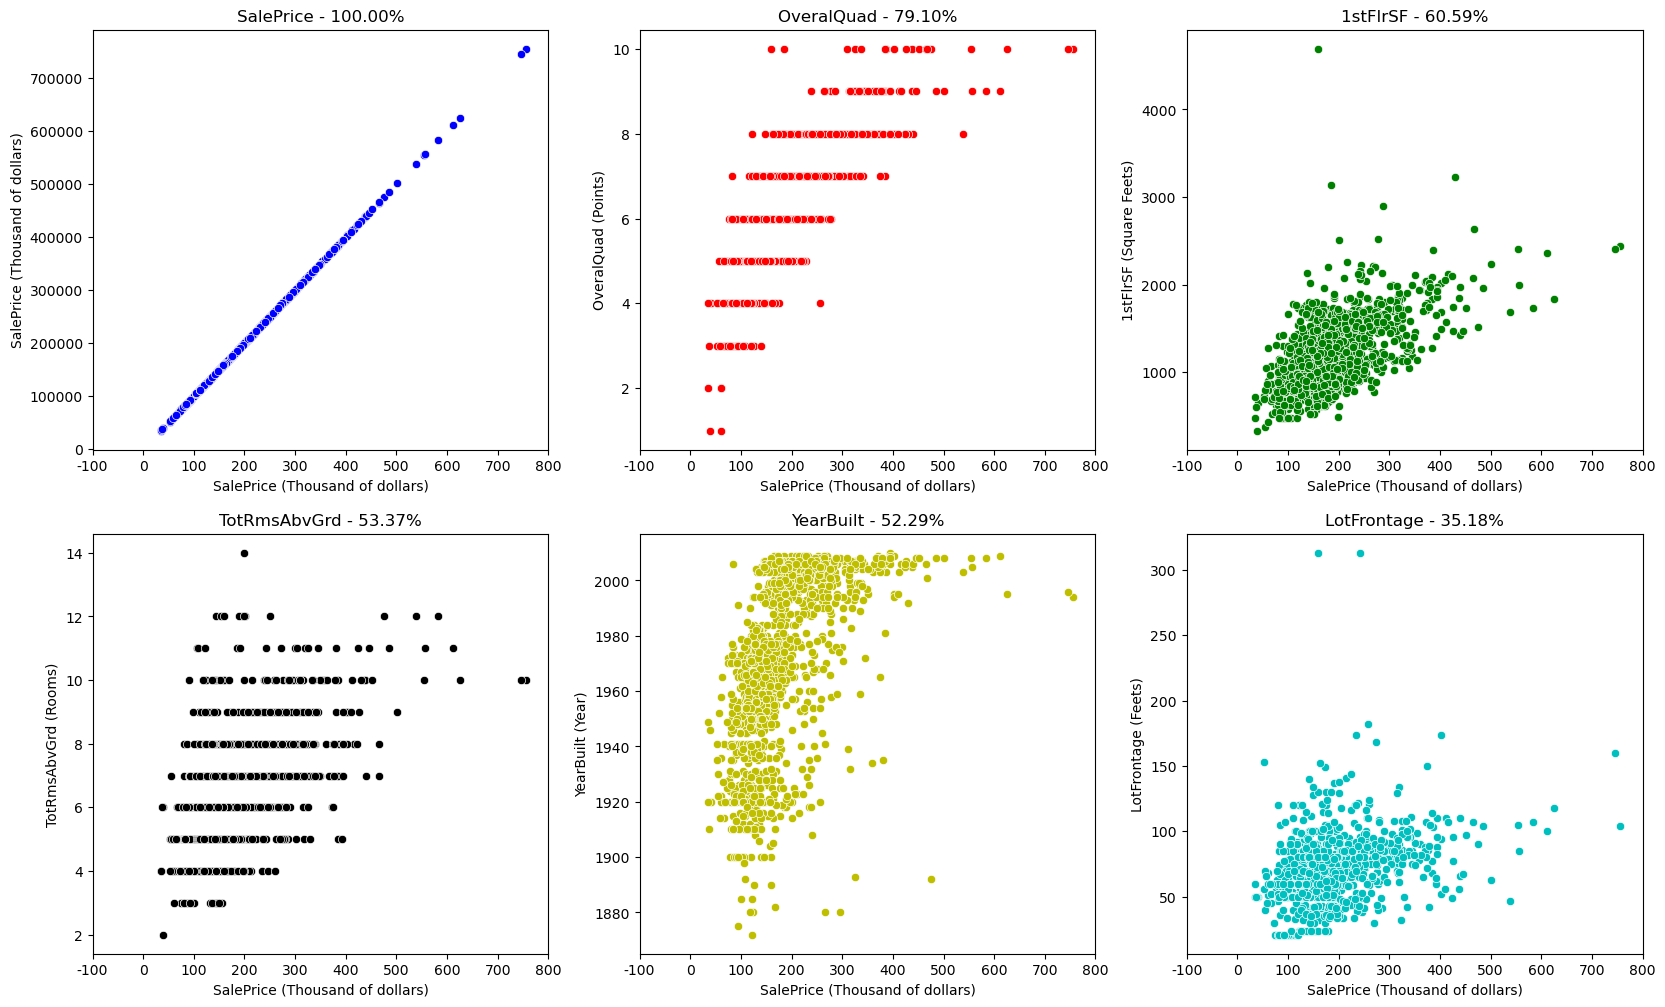

In [7]:
dataset.correlation()

#### Clase para entrenar modelo y mostrar gráficos (pasos 6 - 7)

In [8]:
class LinReg():
    def __init__(self):
        pass

    def entrenar_modelo(self, x, y, epochs, imprimir_error_cada, alpha):
        self.x = x
        self.y = y
        iters = dict()
        vec_err = []
        ones = np.ones_like(x.reshape(-1,1))
        A = np.hstack([x.reshape(-1,1), ones])
        b0 = 10000.0
        b1 = 5000.0
        betas = np.array([b1,b0])
        for n in range(1,epochs+1):
            y_pred = np.matmul(A, betas)
            err = ((y - y_pred)**2).sum()/(2*len(y))
            vec_err.append(err)
            grad = np.matmul((y_pred - y)/len(y), A)
            betas -= alpha*grad
            iters[n] = {'b1':betas[0], 'b0':betas[1]}
            if n%imprimir_error_cada == 0:
                print(f'Iteración {n}: Error {err}')
        self.model = iters
        self.err = np.array(vec_err)
        return iters, np.array(vec_err)
        
    def plot_error(self):
        errSeries = pd.Series(self.err)
        plt.figure(figsize=(15,5))
        plt.plot(errSeries.index, errSeries.values, color='r')
        plt.title('Error del Modelo')
        plt.xlabel('No. Iteración')
        plt.ylabel('Error')
        plt.grid(linewidth=0.5)
        plt.show()

    def plot_model(self, n=5):
        x = np.arange(0,len(self.model)+1,n/2)
        plt.figure(figsize=(15,7))
        for i in range(1,len(self.model)+1):
            if i%n == 0:
                plt.plot(x, self.model[i]['b1']*x + self.model[i]['b0'], 
                         linewidth=1, alpha=0.7,
                         label=f"y = {self.model[i]['b1']:.0f}x + {self.model[i]['b0']:.0f}, iteración: {i}")
        plt.title('Modelos')
        plt.xlabel('x (1e3)')
        plt.ylabel('y(x)')
        plt.xticks(x, [k/1000 for k in x])
        plt.legend()
        plt.grid()
        plt.show()

In [9]:
OvModelClass = LinReg()

In [10]:
y_train_ov = train[:,0]
x_train_ov = train[:,1]

In [11]:
overalQuadModel, OvModelError = OvModelClass.entrenar_modelo(x_train_ov,y_train_ov,100000,5000,1e-3)

Iteración 5000: Error 1426303113.5913174
Iteración 10000: Error 1355413803.28611
Iteración 15000: Error 1311650417.9095614
Iteración 20000: Error 1284633172.412738
Iteración 25000: Error 1267954125.580434
Iteración 30000: Error 1257657346.6853786
Iteración 35000: Error 1251300649.1666517
Iteración 40000: Error 1247376353.6411843
Iteración 45000: Error 1244953697.0139287
Iteración 50000: Error 1243458074.3995008
Iteración 55000: Error 1242534754.5284052
Iteración 60000: Error 1241964744.7036428
Iteración 65000: Error 1241612850.1863723
Iteración 70000: Error 1241395608.7531447
Iteración 75000: Error 1241261495.153772
Iteración 80000: Error 1241178700.3697867
Iteración 85000: Error 1241127587.162124
Iteración 90000: Error 1241096032.517352
Iteración 95000: Error 1241076552.3154202
Iteración 100000: Error 1241064526.2485747


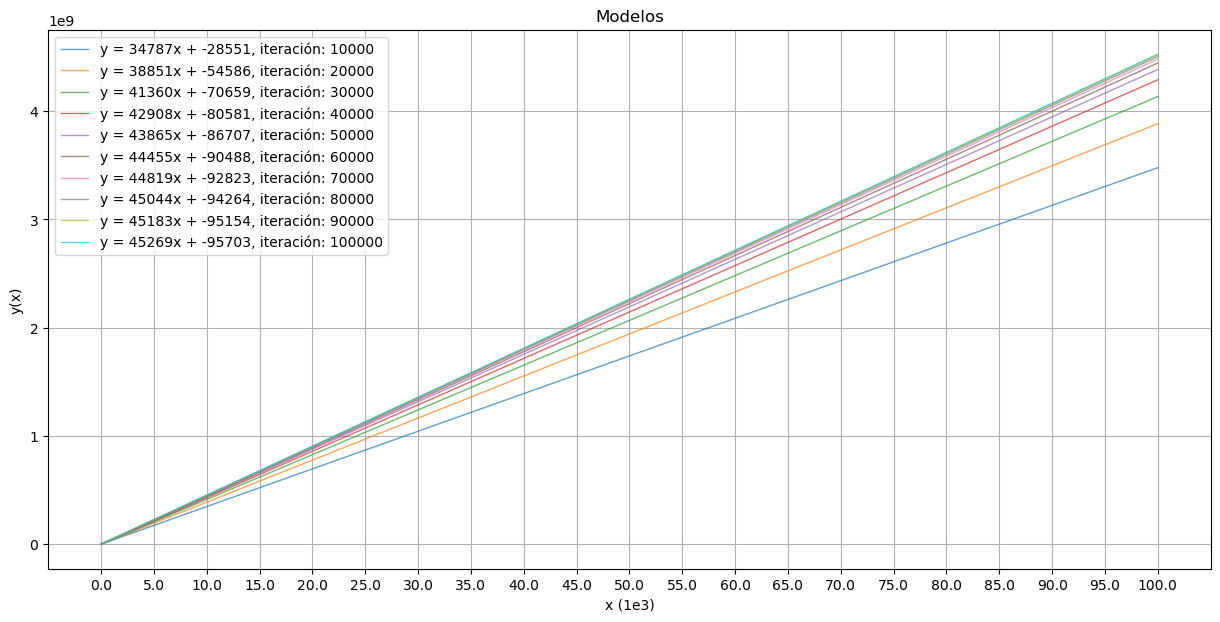

In [12]:
OvModelClass.plot_model(10000)

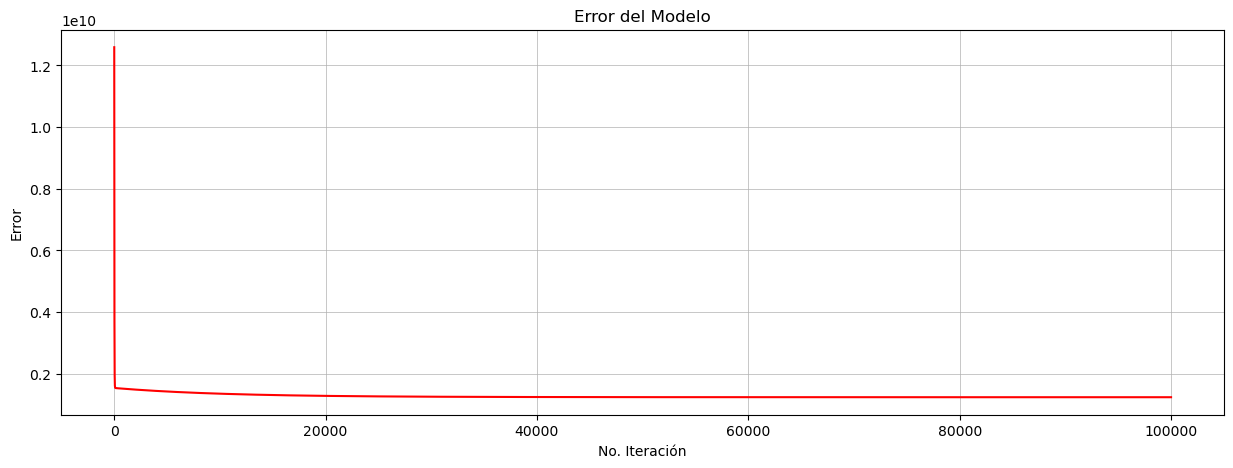

In [13]:
OvModelClass.plot_error()

In [16]:
FrstFlrModelClass = LinReg()

In [14]:
y_train_fl = train[:,0]
x_train_fl = train[:,2]

In [17]:
firstFlrdModel, FlrModelError = FrstFlrModelClass.entrenar_modelo(x_train_fl,y_train_fl,500000,20000,1.3e-6)

Iteración 20000: Error 2108157095.0571802
Iteración 40000: Error 2107984110.2565176
Iteración 60000: Error 2107812022.653548
Iteración 80000: Error 2107640827.5948942
Iteración 100000: Error 2107470520.4513125
Iteración 120000: Error 2107301096.6175697
Iteración 140000: Error 2107132551.5123181
Iteración 160000: Error 2106964880.5779705
Iteración 180000: Error 2106798079.28058
Iteración 200000: Error 2106632143.1097128
Iteración 220000: Error 2106467067.578331
Iteración 240000: Error 2106302848.222668
Iteración 260000: Error 2106139480.602108
Iteración 280000: Error 2105976960.2990692
Iteración 300000: Error 2105815282.9188793
Iteración 320000: Error 2105654444.08966
Iteración 340000: Error 2105494439.4622095
Iteración 360000: Error 2105335264.7098815
Iteración 380000: Error 2105176915.5284715
Iteración 400000: Error 2105019387.6360981
Iteración 420000: Error 2104862676.7730896
Iteración 440000: Error 2104706778.7018652
Iteración 460000: Error 2104551689.2068245
Iteración 480000: Error

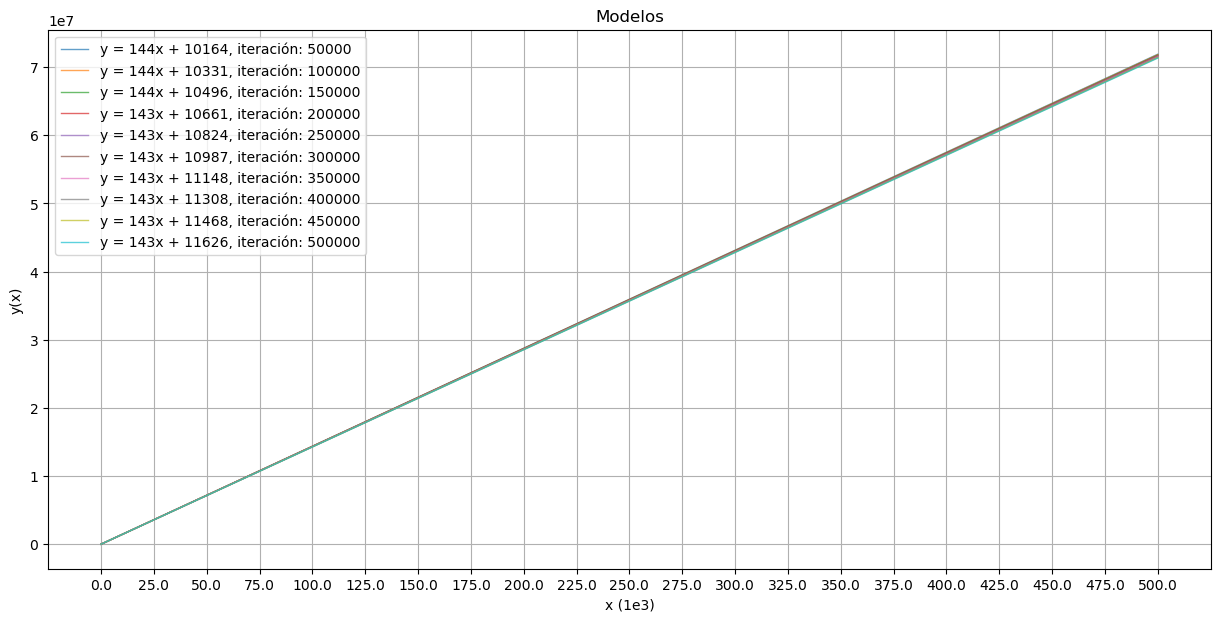

In [18]:
FrstFlrModelClass.plot_model(50000)

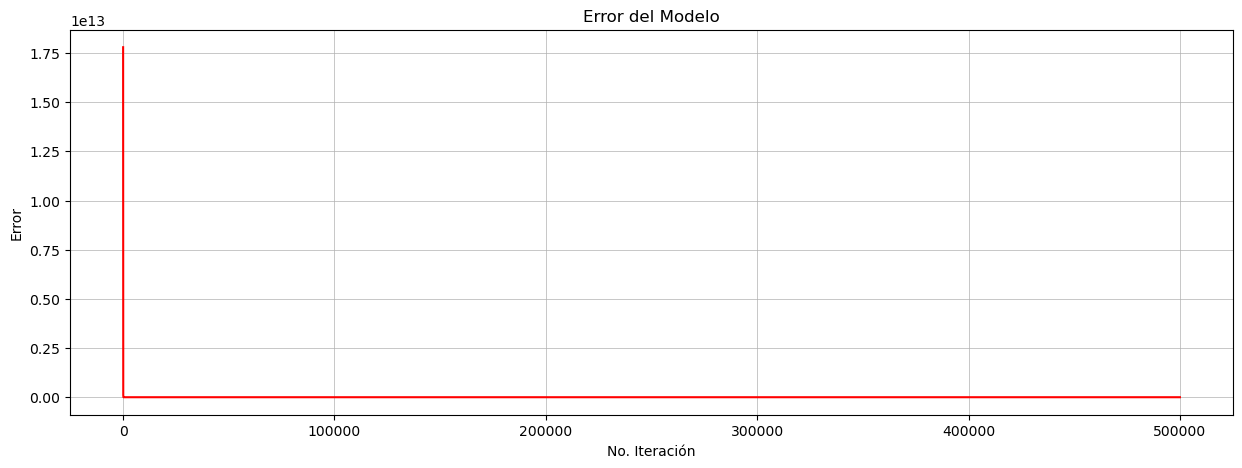

In [19]:
FrstFlrModelClass.plot_error()

### Modelo con Scikit-learn

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
OvReg = LinearRegression().fit(x_train_ov.reshape(-1, 1), y_train_ov.reshape(-1, 1))

In [26]:
FlrReg = LinearRegression().fit(x_train_fl.reshape(-1, 1), y_train_fl.reshape(-1, 1))

### Modelo promediado

In [27]:
def avg_model(manualModel, sckikitModel, x):
    manualModel = manualModel[np.max(list(manualModel.keys()))]
    y_manual = manualModel['b1']*x + manualModel['b0']
    y_scikit = float(sckikitModel.coef_)*x + float(sckikitModel.intercept_)
    y_prom = (y_manual + y_scikit)/2
    return y_manual, y_scikit, y_prom

### ¿El mejor modelo?

In [28]:
x_test_ov = test[:,1]
OvManual, OvSci, OvAvg = avg_model(overalQuadModel, OvReg, x_test_ov)

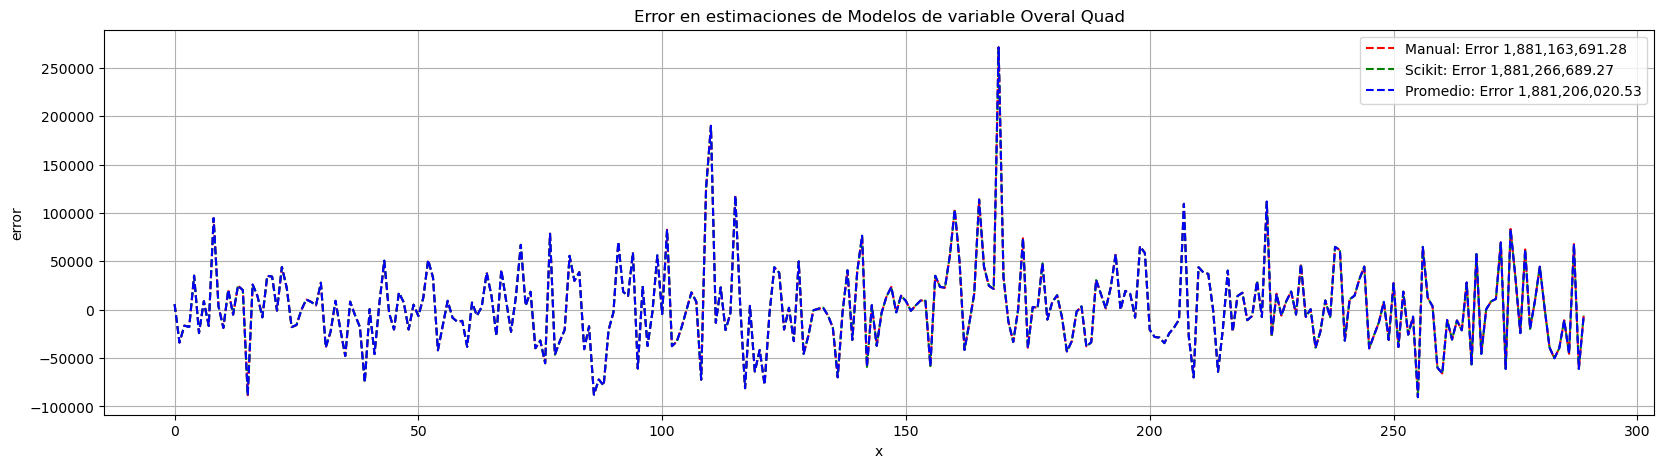

In [29]:
plt.figure(figsize=(20,5))
x = np.arange(len(x_test_ov))
errorManual = (test[:,0] - OvManual)
errorScik = (test[:,0] - OvSci)
errorAvg = (test[:,0] - OvAvg)
plt.plot(x, errorManual, 'r--', label=f'Manual: Error {np.square(errorManual).sum()/len(errorManual):,.2f}')
plt.plot(x, errorScik, 'g--', label=f'Scikit: Error {np.square(errorScik).sum()/len(errorScik):,.2f}')
plt.plot(x, errorAvg, 'b--', label=f'Promedio: Error {np.square(errorAvg).sum()/len(errorAvg):,.2f}')
plt.xlabel('x')
plt.ylabel('error')
plt.title('Error en estimaciones de Modelos de variable Overal Quad')
plt.legend()
plt.grid()
plt.show()

**De acuerdo al gráfico anterior, se concluye que el mejor modelo es el obtenido de forma Manual**

In [30]:
x_test_fst = test[:,2]
FrstManual, FrstSci, FrstAvg = avg_model(firstFlrdModel, FlrReg, x_test_fst)

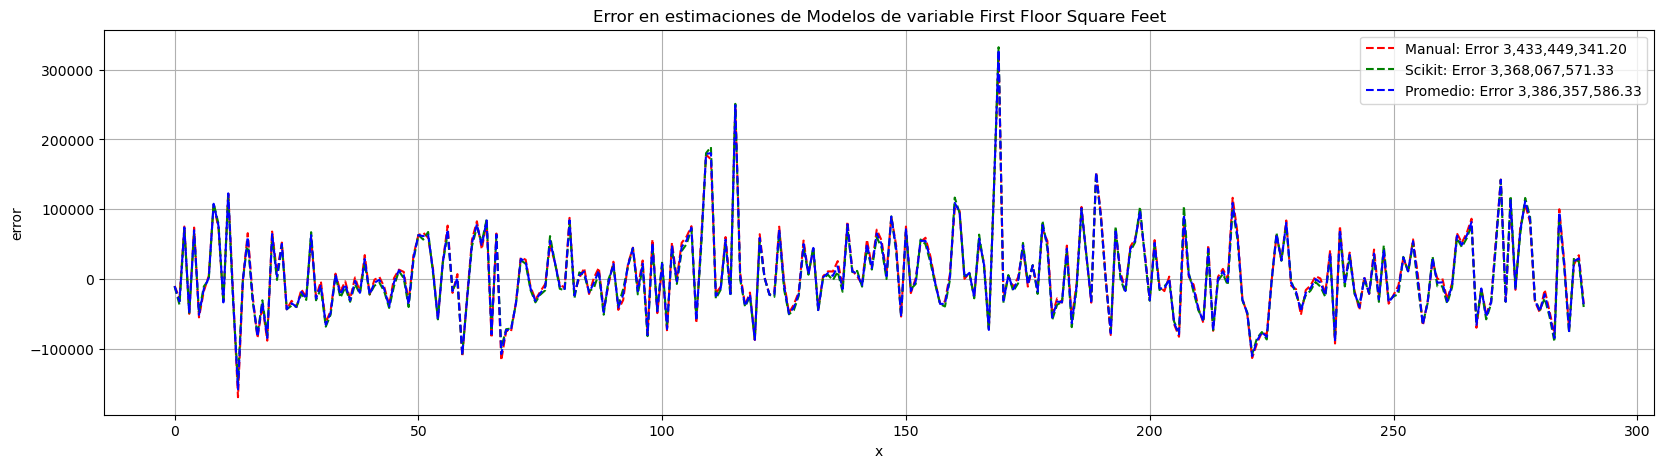

In [31]:
plt.figure(figsize=(20,5))
x = np.arange(len(x_test_ov))
errorManual = (test[:,0] - FrstManual)
errorScik = (test[:,0] - FrstSci)
errorAvg = (test[:,0] - FrstAvg)
plt.plot(x, errorManual, 'r--', label=f'Manual: Error {np.square(errorManual).sum()/len(errorManual):,.2f}')
plt.plot(x, errorScik, 'g--', label=f'Scikit: Error {np.square(errorScik).sum()/len(errorScik):,.2f}')
plt.plot(x, errorAvg, 'b--', label=f'Promedio: Error {np.square(errorAvg).sum()/len(errorAvg):,.2f}')
plt.xlabel('x')
plt.ylabel('error')
plt.title('Error en estimaciones de Modelos de variable First Floor Square Feet')
plt.legend()
plt.grid()
plt.show()

**De acuerdo al gráfico anterior, se concluye que el mejor modelo es el obtenido por Scikit Learn**

## Git